# Herdez Forecasting Project

**Notebook created on:** 2024-09-14


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical
import statsmodels.api as sm
from scipy import stats

# settings
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

%time


CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
# dataset
df = pd.read_csv("..\\data\\raw\\test_seriedatos_arquitectodatascience -.csv")
df.head()

,Anio,Semana,Sucursal,Cadena,Nivel Socioeconomico,Recurso,Venta_piezas,Venta_valor,Precio,Promocion
0,2020,46,Norte 286,SA,D/E,68524 Alimentos,226,4429.00,19.597345,0
1,2021,20,Norte 286,SA,D/E,68524 Alimentos,154,2754.81,17.888377,1
2,2018,23,Norte 286,SA,D/E,68524 Alimentos,228,3176.59,13.932412,1
3,2021,37,Norte 286,SA,D/E,68524 Alimentos,163,3112.00,19.092025,0
4,2020,10,Norte 286,SA,D/E,68524 Alimentos,212,3885.50,18.327830,0


In [4]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Anio                  228 non-null    int64  
 1   Semana                228 non-null    int64  
 2   Sucursal              228 non-null    object 
 3   Cadena                228 non-null    object 
 4   Nivel Socioeconomico  228 non-null    object 
 5   Recurso               228 non-null    object 
 6   Venta_piezas          228 non-null    int64  
 7   Venta_valor           228 non-null    float64
 8   Precio                228 non-null    float64
 9   Promocion             228 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 17.9+ KB


In [5]:
# Summary statistics
df.describe()

,Anio,Semana,Venta_piezas,Venta_valor,Precio,Promocion
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,2019.600877,25.964912,280.973684,4862.312412,16.963465,0.210526
std,1.288170,15.642160,232.733875,3792.396837,3.641197,0.408579
min,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.750000,12.000000,162.750000,2621.562500,15.493020,0.000000
50%,2020.000000,25.500000,212.000000,3722.245000,17.305048,0.000000
75%,2021.000000,40.000000,306.250000,5567.392500,19.104837,0.000000
max,2022.000000,53.000000,1807.000000,25034.500000,22.500000,1.000000


In [6]:
# Checking for missing values
df.isnull().sum()

Anio                    0
Semana                  0
Sucursal                0
Cadena                  0
Nivel Socioeconomico    0
Recurso                 0
Venta_piezas            0
Venta_valor             0
Precio                  0
Promocion               0
dtype: int64

### Observación de Datos con Valores en Cero
Al ejecutar df.describe(), se detecta al menos una muestra en la que los campos Venta_piezas, Venta_valor, y Precio son 0.

### Posibles Escenarios:
### Escenario 1: Los ceros representan ventas nulas (ventas de 0 unidades)
Interpretación: El producto no se vendió durante esa semana o se encontraba agotado.
Acción: Conservar estos registros, ya que reflejan una demanda nula o un problema de inventario. 

### Escenario 2: Los ceros representan datos faltantes
Interpretación: La información no fue registrada correctamente.
Acción: Tratar estos valores como datos faltantes. Dependiendo del análisis, se puede optar por estimar los valores (imputación) o excluir los registros afectados.

### Consideraciones:
Validar si, según las reglas de negocio, un producto fuera de stock también tiene asignado un precio = 0.
Si este es el caso, estos registros deben conservarse como en el Escenario 1. Sin embargo, si los ceros en el precio no son un indicador de falta de stock, se deben tratar como datos faltantes, siguiendo el Escenario 2.

Para efectos de la limpieza de datos en este análisis, se asumirá que los ceros representan datos faltantes y, por lo tanto, se procederá con las acciones del Escenario 2.

In [7]:
### Check Proportion
samples_with_zero_price = df["Precio"] == 0
zero_price_proportion = samples_with_zero_price.mean()
print(f"Proporcion de muestras con precio cero: {zero_price_proportion:.2%}")

Proporcion de muestras con precio cero: 2.63%


### Estimación de Valores Faltantes mediante Media y KNN
Se opta por la estimación de valores faltantes utilizando el cálculo de la media. Sin embargo, una alternativa más robusta para la imputación de datos es el uso de modelos de agrupación como K-Nearest Neighbors (KNN), que permite estimar valores faltantes basándose en la similitud entre registros.

### Consideraciones para KNN
Para aplicar KNN correctamente, es necesario transformar las variables categóricas (Anio hasta Recurso) a valores numéricos. Ya que KNN trabaja con distancias numéricas.

In [8]:
### Replace 0 with NaN

df[["Venta_piezas", "Venta_valor", "Precio"]] = df[
    ["Venta_piezas", "Venta_valor", "Precio"]
].replace(0, pd.NA)

with pd.option_context("future.no_silent_downcasting", True):
    # Estimar 'Precio' and ensure it's numeric
    df["Precio"] = pd.to_numeric(
        df["Precio"].infer_objects().fillna(df["Precio"].mean())
    )

    # Estimar 'Venta_piezas' and ensure it's numeric
    df["Venta_piezas"] = pd.to_numeric(
        df["Venta_piezas"].infer_objects().fillna(df["Venta_piezas"].mean())
    )

# Recalculate 'Venta_valor'
df["Venta_valor"] = df["Venta_piezas"] * df["Precio"]

# Ensure 'Venta_valor' is numeric
df["Venta_valor"] = pd.to_numeric(df["Venta_valor"])

df.describe()

,Anio,Semana,Venta_piezas,Venta_valor,Precio,Promocion
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,2019.600877,25.964912,288.567568,4994.612569,17.421937,0.210526
std,1.288170,15.642160,228.083265,3706.819783,2.333834,0.408579
min,2017.000000,1.000000,65.000000,911.500000,12.190882,0.000000
25%,2018.750000,12.000000,166.750000,2752.007500,15.699016,0.000000
50%,2020.000000,25.500000,218.500000,3870.540000,17.421937,0.000000
75%,2021.000000,40.000000,306.250000,5567.392501,19.104837,0.000000
max,2022.000000,53.000000,1807.000000,25034.500007,22.500000,1.000000


In [9]:
df.dtypes

Anio                      int64
Semana                    int64
Sucursal                 object
Cadena                   object
Nivel Socioeconomico     object
Recurso                  object
Venta_piezas            float64
Venta_valor             float64
Precio                  float64
Promocion                 int64
dtype: object

In [10]:
df["Sucursal"].value_counts()

Sucursal
Norte 286    228
Name: count, dtype: int64

In [11]:
df["Cadena"].value_counts()

Cadena
SA    228
Name: count, dtype: int64

In [12]:
df["Nivel Socioeconomico"].value_counts()

Nivel Socioeconomico
D/E    228
Name: count, dtype: int64

In [13]:
df["Recurso"].value_counts()

Recurso
68524 Alimentos    228
Name: count, dtype: int64

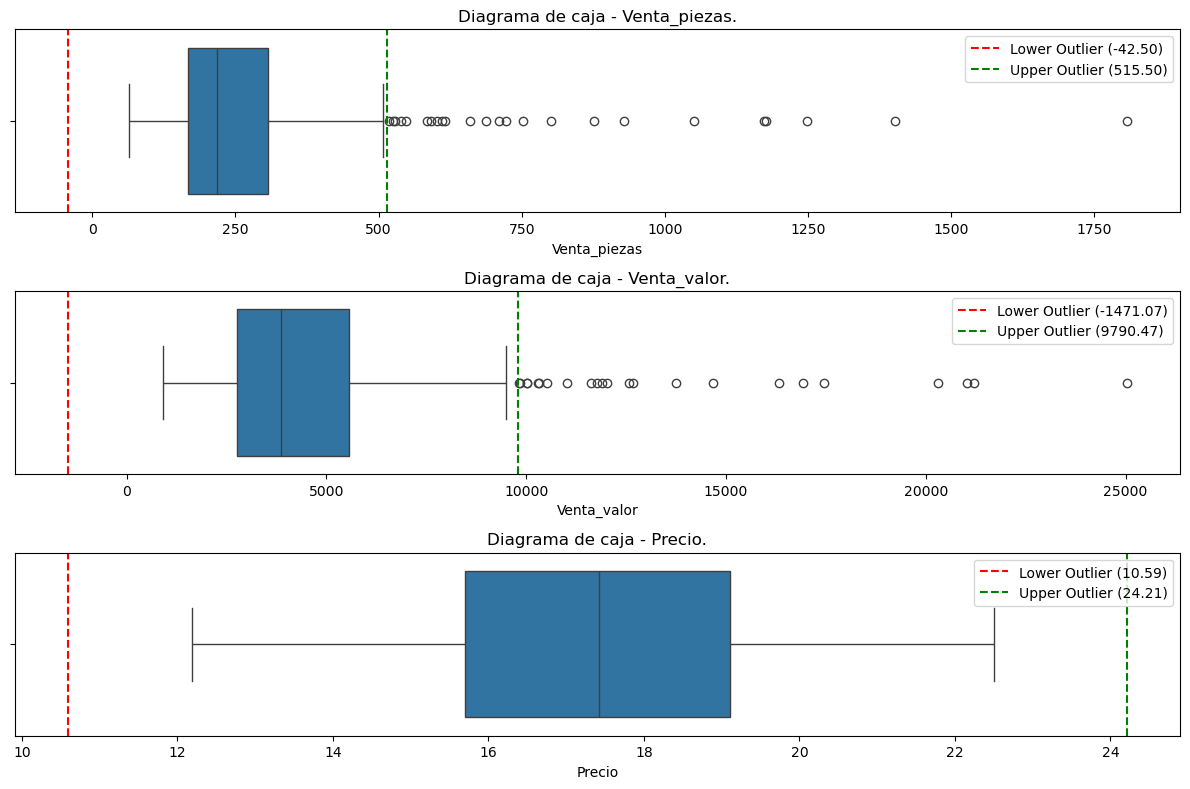

In [14]:
# Function to calculate outlier boundaries
def outlier_boundaries(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


plt.figure(figsize=(12, 8))

### Diagrama de caja - Venta_piezas.
plt.subplot(3, 1, 1)
sns.boxplot(x="Venta_piezas", data=df)
lower, upper = outlier_boundaries("Venta_piezas")
plt.axvline(lower, color="red", linestyle="--", label=f"Lower Outlier ({lower:.2f})")
plt.axvline(upper, color="green", linestyle="--", label=f"Upper Outlier ({upper:.2f})")
plt.legend()
plt.title("Diagrama de caja - Venta_piezas.")

### Diagrama de caja - Venta_valor
plt.subplot(3, 1, 2)
sns.boxplot(x="Venta_valor", data=df)
lower, upper = outlier_boundaries("Venta_valor")
plt.axvline(lower, color="red", linestyle="--", label=f"Lower Outlier ({lower:.2f})")
plt.axvline(upper, color="green", linestyle="--", label=f"Upper Outlier ({upper:.2f})")
plt.legend()
plt.title("Diagrama de caja - Venta_valor.")

### Diagrama de caja - Precio
plt.subplot(3, 1, 3)
sns.boxplot(x="Precio", data=df)
lower, upper = outlier_boundaries("Precio")
plt.axvline(lower, color="red", linestyle="--", label=f"Lower Outlier ({lower:.2f})")
plt.axvline(upper, color="green", linestyle="--", label=f"Upper Outlier ({upper:.2f})")
plt.legend()
plt.title("Diagrama de caja - Precio.")

# Adjust layout
plt.tight_layout()
plt.show()

Se observan datos atípicos, que representan ventas excepcionales, es importante no eliminarlos ya que pueden contener información valiosa sobre eventos especiales que afectan el comportamiento de las ventas.

<Axes: xlabel='Anio,Semana'>

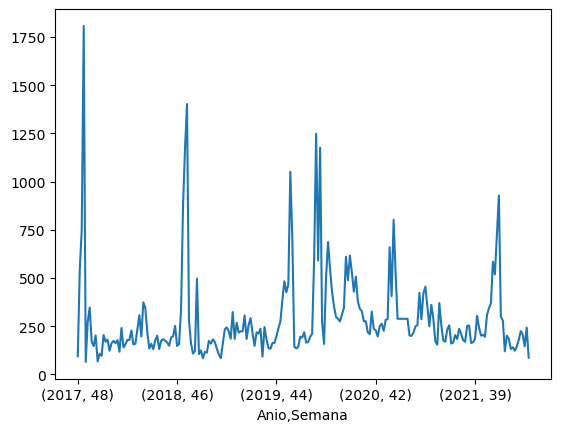

In [15]:
df.groupby(["Anio", "Semana"])["Venta_piezas"].sum().plot()

<Axes: xlabel='Promocion', ylabel='Venta_piezas'>

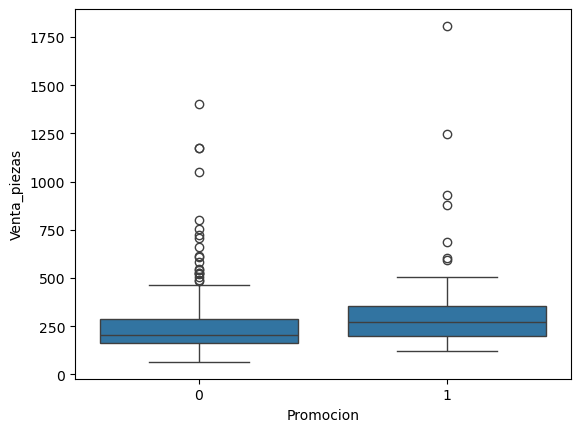

In [16]:
sns.boxplot(x="Promocion", y="Venta_piezas", data=df)

<Axes: xlabel='Anio,Semana'>

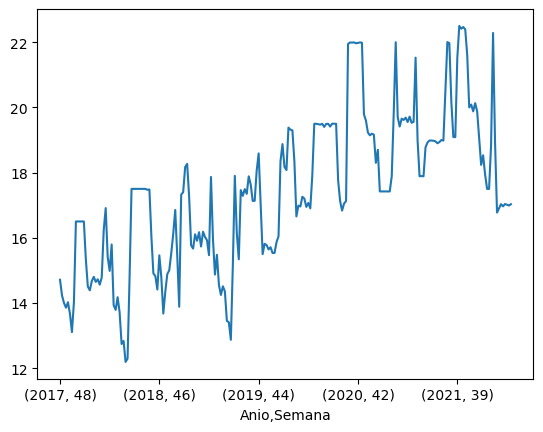

In [18]:
df.groupby(["Anio", "Semana"])["Precio"].sum().plot()

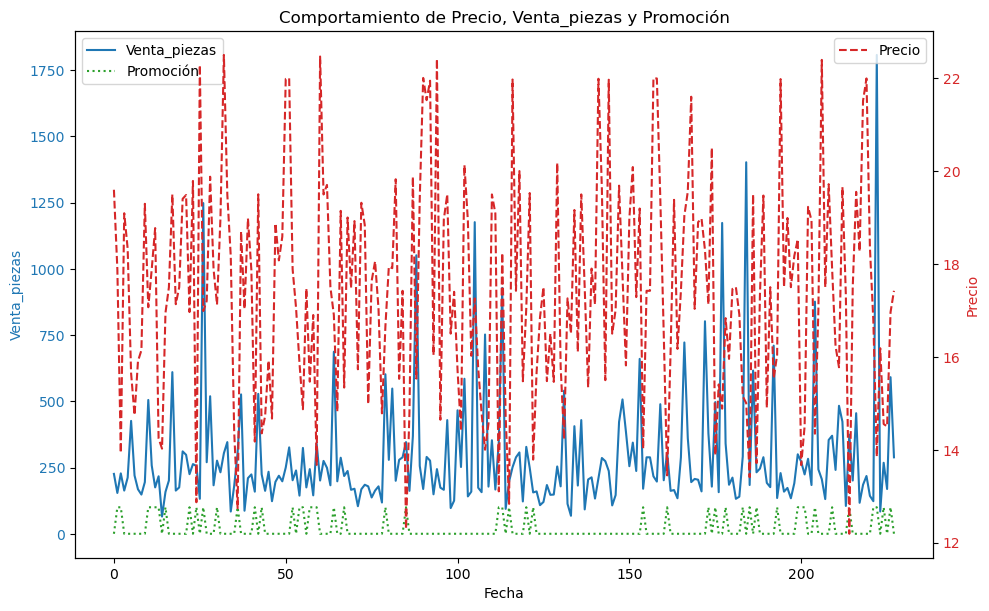

In [19]:
# Crear una figura y un conjunto de ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Venta_piezas en el eje principal (izquierdo)
color = "tab:blue"
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Venta_piezas", color=color)
ax1.plot(df.index, df["Venta_piezas"], color=color, label="Venta_piezas")
ax1.tick_params(axis="y", labelcolor=color)

# Crear un segundo eje para graficar el Precio
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Precio", color=color)
ax2.plot(df.index, df["Precio"], color=color, label="Precio", linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)

# Graficar la Promoción en el eje principal
color = "tab:green"
ax1.plot(df.index, df["Promocion"] * 100, color=color, label="Promoción", linestyle=":")

fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Mostrar la gráfica
plt.title("Comportamiento de Precio, Venta_piezas y Promoción")
plt.show()